In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py # pour gérer les formats de données utilisés ici

!pip install torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device : {device}")

Utilisation du device : cuda


## Tristan Lecourtois et Paul Rongieras

# Reconnaissance de signaux de communication par apprentissage profond

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétique comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [ ]:
data_path = 'samples.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [ ]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering

In [ ]:
data_path = 'train.hdf5'
data = h5py.File(data_path , 'r')
signals_train = np.array(data['signaux'])
snr_train =  np.array(data['snr'])
labels_id_train = np.array(data['labels'])
data.close()

data_path = 'test.hdf5'
data = h5py.File(data_path , 'r')
signals_test = np.array(data['signaux'])
snr_test =  np.array(data['snr'])
labels_id_test = np.array(data['labels'])
data.close()

data_path = 'validation.hdf5'
data = h5py.File(data_path , 'r')
signals_valid = np.array(data['signaux'])
snr_valid =  np.array(data['snr'])
labels_id_valid = np.array(data['labels'])
data.close()

In [ ]:
print("le train set est de taille :", signals_train.shape)
print("le test set est de taille :", signals_test.shape)
print("le test set est de taille :", signals_valid.shape)
print("\n")
unique, counts = np.unique(labels_id_train, return_counts=True)
print("Répartition des classes au sein du train set :\n",dict(zip(unique, counts)))
unique, counts = np.unique(labels_id_test, return_counts=True)
print("Répartition des classes au sein du test set :\n",dict(zip(unique, counts)))
unique, counts = np.unique(labels_id_valid, return_counts=True)
print("Répartition des classes au sein du validation set :\n",dict(zip(unique, counts)))
print("\n")
print("la distribution des classes est équilibrée")
print("\n")
unique, counts = np.unique(snr_train, return_counts=True)
print("Répartition des SNR au sein du train set :\n",dict(zip(unique, counts)))
unique, counts = np.unique(snr_test, return_counts=True)
print("Répartition des SNR au sein du test set :\n",dict(zip(unique, counts)))
unique, counts = np.unique(snr_valid, return_counts=True)
print("Répartition des SNR au sein du validation set :\n",dict(zip(unique, counts)))
print("\n")
print("la distribution des SNR est équilibrée")

le train set est de taille : (30000, 2048, 2)
le test set est de taille : (10000, 2048, 2)
le test set est de taille : (10000, 2048, 2)


Répartition des classes au sein du train set :
 {np.int8(0): np.int64(5143), np.int8(1): np.int64(4968), np.int8(2): np.int64(5053), np.int8(3): np.int64(4867), np.int8(4): np.int64(4894), np.int8(5): np.int64(5075)}
Répartition des classes au sein du test set :
 {np.int8(0): np.int64(1697), np.int8(1): np.int64(1650), np.int8(2): np.int64(1653), np.int8(3): np.int64(1653), np.int8(4): np.int64(1684), np.int8(5): np.int64(1663)}
Répartition des classes au sein du validation set :
 {np.int8(0): np.int64(1653), np.int8(1): np.int64(1745), np.int8(2): np.int64(1590), np.int8(3): np.int64(1639), np.int8(4): np.int64(1660), np.int8(5): np.int64(1713)}


la distribution des classes est équilibrée


Répartition des SNR au sein du train set :
 {np.int16(0): np.int64(7660), np.int16(10): np.int64(7640), np.int16(20): np.int64(7020), np.int16(30): np.int64(768

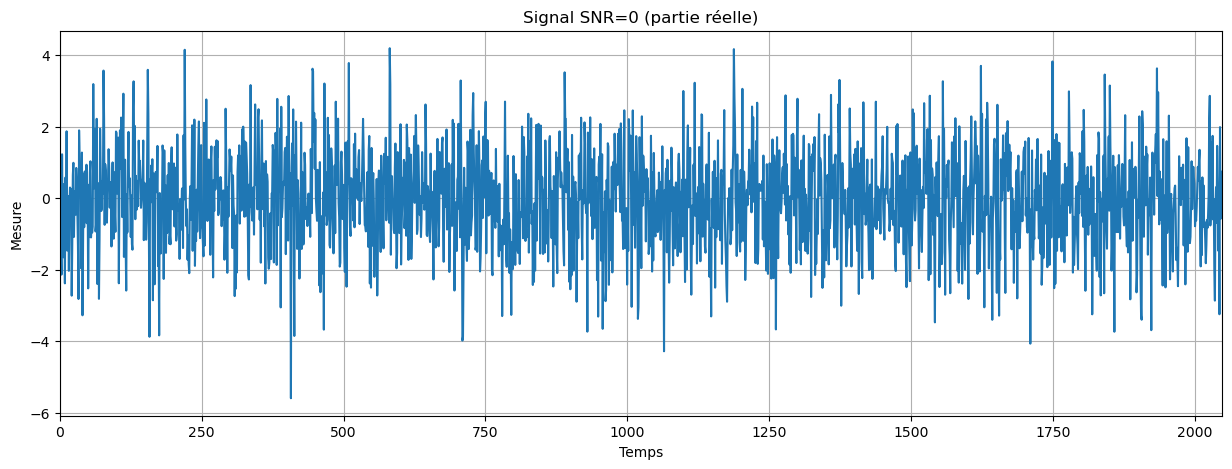

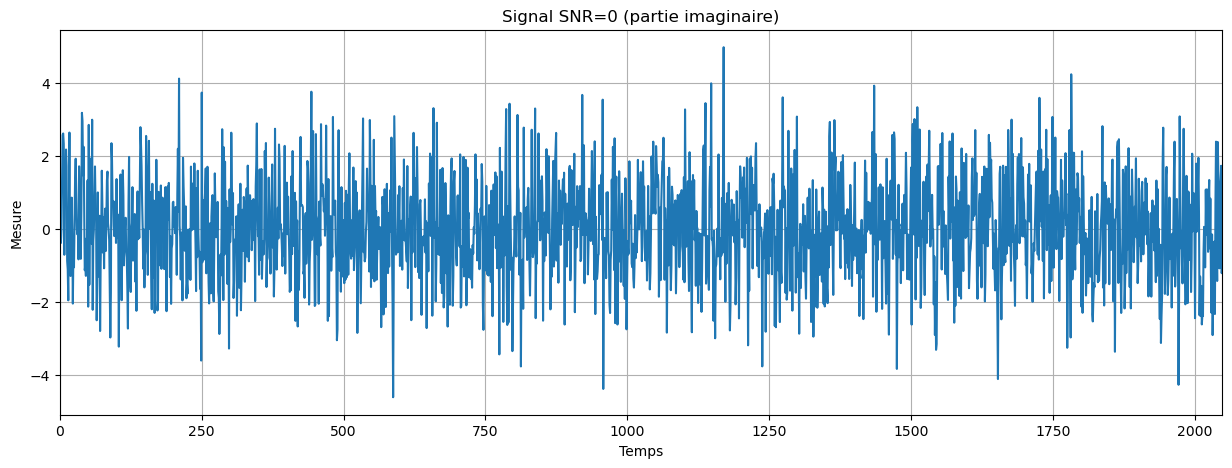

In [ ]:
# Exemple signal avec SNR de 0
idx0 = np.where(snr == 0)[0]
signals0 = signals[idx0]
signal0 = signals0[0,:,:]
signal0reel = signal0[:,0]
signal0im = signal0[:,1]

duree = signal0reel.shape[0]
t = np.linspace(0, duree, signal0reel.shape[0])
plt.figure(figsize=(15, 5))
plt.plot(t, signal0reel)
plt.xlabel('Temps')
plt.ylabel('Mesure')
plt.title('Signal SNR=0 (partie réelle)')
plt.xlim(0, duree)
plt.grid()
plt.show()

duree = signal0im.shape[0]
t = np.linspace(0, duree, signal0im.shape[0])
plt.figure(figsize=(15, 5))
plt.plot(t, signal0im)
plt.xlabel('Temps')
plt.ylabel('Mesure')
plt.title('Signal SNR=0 (partie imaginaire)')
plt.xlim(0, duree)
plt.grid()
plt.show()

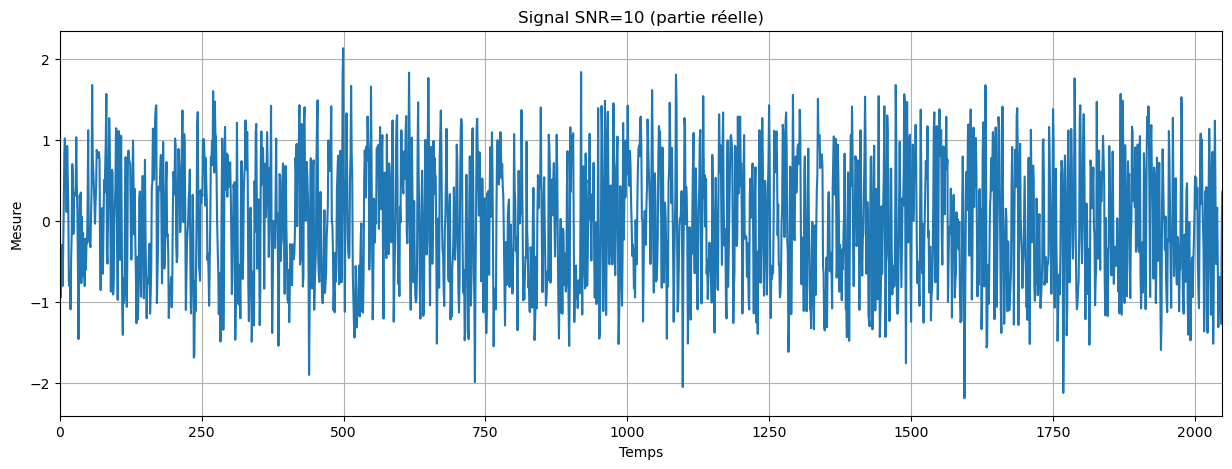

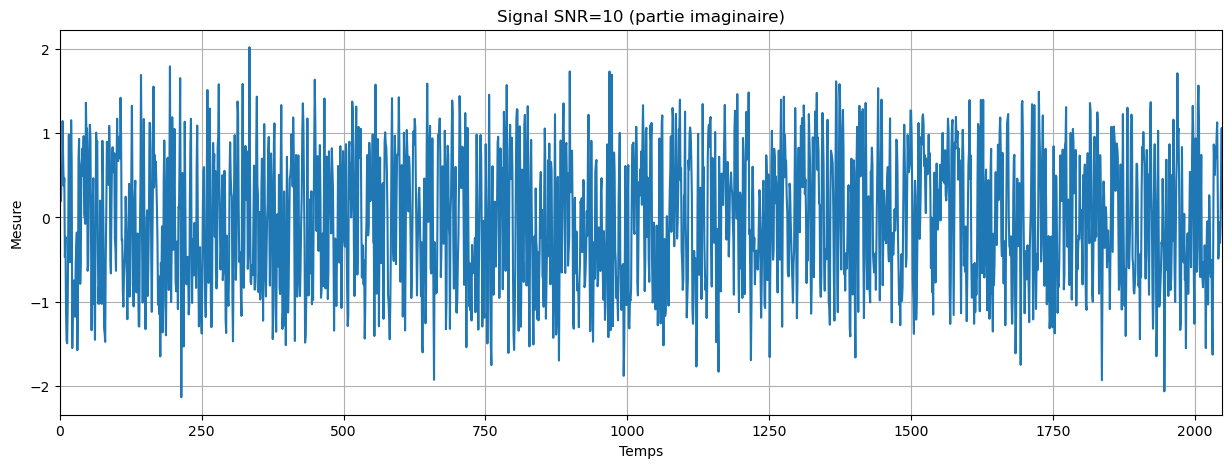

In [ ]:
# Exemple signal avec SNR de 10
idx10 = np.where(snr == 10)[0]
signals10 = signals[idx10]
signal10 = signals10[0,:,:]
signal10reel = signal10[:,0]
signal10im = signal10[:,1]

duree = signal10reel.shape[0]
t = np.linspace(0, duree, signal10reel.shape[0])
plt.figure(figsize=(15, 5))
plt.plot(t, signal10reel)
plt.xlabel('Temps')
plt.ylabel('Mesure')
plt.title('Signal SNR=10 (partie réelle)')
plt.xlim(0, duree)
plt.grid()
plt.show()

duree = signal10im.shape[0]
t = np.linspace(0, duree, signal10im.shape[0])
plt.figure(figsize=(15, 5))
plt.plot(t, signal10im)
plt.xlabel('Temps')
plt.ylabel('Mesure')
plt.title('Signal SNR=10 (partie imaginaire)')
plt.xlim(0, duree)
plt.grid()
plt.show()

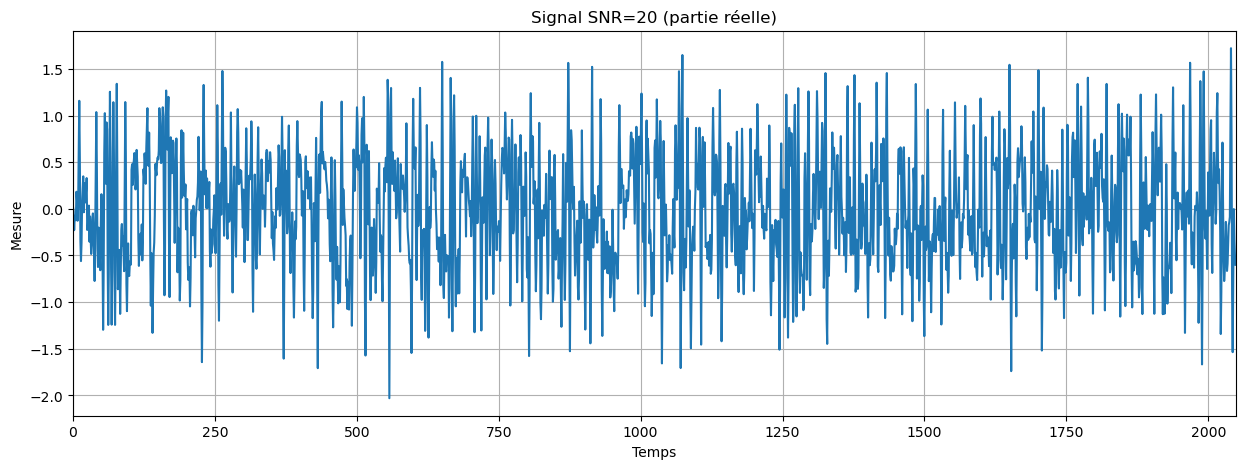

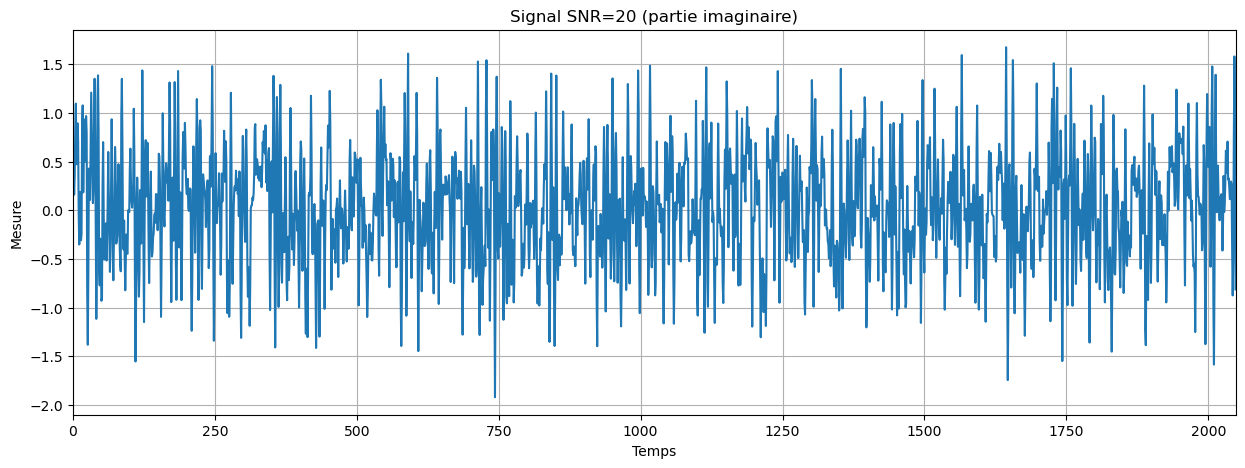

In [ ]:
# Exemple signal avec SNR de 20
idx20 = np.where(snr == 20)[0]
signals20 = signals[idx20]
signal20 = signals20[0,:,:]
signal20reel = signal20[:,0]
signal20im = signal20[:,1]

duree = signal20reel.shape[0]
t = np.linspace(0, duree, signal20reel.shape[0])
plt.figure(figsize=(15, 5))
plt.plot(t, signal20reel)
plt.xlabel('Temps')
plt.ylabel('Mesure')
plt.title('Signal SNR=20 (partie réelle)')
plt.xlim(0, duree)
plt.grid()
plt.show()

duree = signal20im.shape[0]
t = np.linspace(0, duree, signal20im.shape[0])
plt.figure(figsize=(15, 5))
plt.plot(t, signal20im)
plt.xlabel('Temps')
plt.ylabel('Mesure')
plt.title('Signal SNR=20 (partie imaginaire)')
plt.xlim(0, duree)
plt.grid()
plt.show()

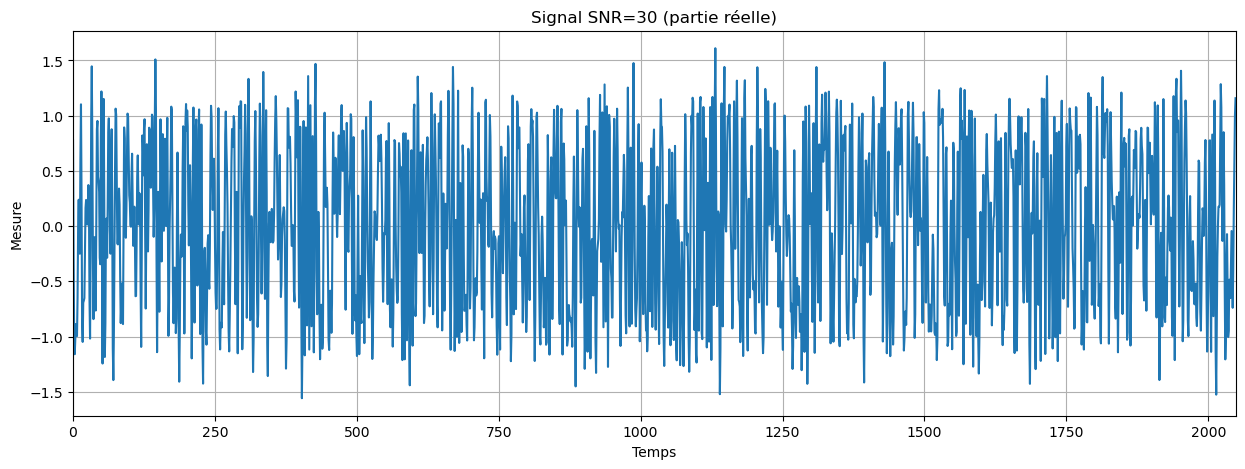

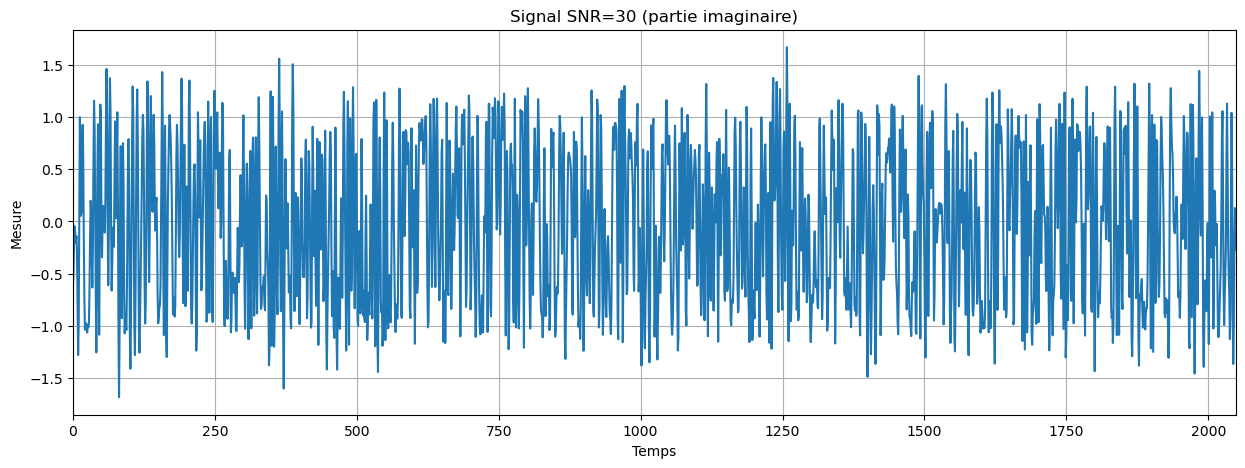

In [ ]:
# Exemple signal avec SNR de 30
idx30 = np.where(snr == 30)[0]
signals30 = signals[idx30]
signal30 = signals30[0,:,:]
signal30reel = signal30[:,0]
signal30im = signal30[:,1]

duree = signal30reel.shape[0]
t = np.linspace(0, duree, signal30reel.shape[0])
plt.figure(figsize=(15, 5))
plt.plot(t, signal30reel)
plt.xlabel('Temps')
plt.ylabel('Mesure')
plt.title('Signal SNR=30 (partie réelle)')
plt.xlim(0, duree)
plt.grid()
plt.show()

duree = signal30im.shape[0]
t = np.linspace(0, duree, signal30im.shape[0])
plt.figure(figsize=(15, 5))
plt.plot(t, signal30im)
plt.xlabel('Temps')
plt.ylabel('Mesure')
plt.title('Signal SNR=30 (partie imaginaire)')
plt.xlim(0, duree)
plt.grid()
plt.show()

*Comment*: On observe logiquement que les signaux avec un SNR faible (beaucoup de bruit) sont mesurés sur une amplitude plus importante.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, labels_id, signals):
        self.labels_id = torch.tensor(labels_id, dtype=torch.long)
        self.signals = torch.tensor(signals, dtype=torch.float32)

    def __len__(self):
        return len(self.labels_id)

    def __getitem__(self, i):
        signal_tc = self.signals[i]
        # On passe de [T, C] à [C, T] :
        signal_ct = signal_tc.permute(1, 0)
        label = self.labels_id[i]

        return signal_ct, label

In [ ]:
dataset = MyDataset(labels_id, signals)

In [ ]:
dataloader = DataLoader(dataset,
                        batch_size=50,
                        shuffle=True
                       )

dataset_train = MyDataset(labels_id_train, signals_train)
dataloader_train = DataLoader(dataset_train,
                        batch_size=50,
                        shuffle=True
                       )

dataset_valid = MyDataset(labels_id_valid, signals_valid)
dataloader_valid = DataLoader(dataset_valid,
                        batch_size=50,
                        shuffle=False
                       )

## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce modèle doit comporter moins de 10000 paramètres libres.

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin.

In [ ]:
class DumbModel(torch.nn.Module):
    """
    Modèle "dumb" [B, C, T] -> [B, N]

    Args:
      C : nombre de canaux en entrée
      N : nombre de classes en sortie

    """
    def __init__(self, C_in, N_out):
        super().__init__()
        self.pipeline = nn.Sequential(
            # Entrée: [B, C, T]
            # Sortie: [B, C, 1]
            nn.AdaptiveAvgPool1d(output_size=1),
            # Entrée: [B, C, 1]
            # Sortie: [B, C]
            nn.Flatten(start_dim=1),
            # Entrée: [B, C]
            # Sortie: [B, N] (logits)
            nn.Linear(in_features=C_in, out_features=N_out),
            # Entrée: [B, N] (logits)
            # Sortie: [B, N] (log-probas)
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.pipeline(x)


In [ ]:
dumb = DumbModel(C_in=2, N_out=6)
print(dumb)

DumbModel(
  (pipeline): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=2, out_features=6, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante :

In [ ]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [ ]:
count_n_param(dumb)

18

Le calcul provient de l'unique couche entraînable, nn.Linear(in_features=C_in, out_features=N_out) :

Poids : C_in×N_out=2×6=12

Biais : N_out=6

Total : 12+6=18

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [ ]:
model = DumbModel(C_in=2, N_out=6)

loss = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters())

val_accuracy_metric = MulticlassAccuracy(num_classes=6).to(device)

n_epochs = 30
# batch_size = 50 dans le dataloader

chemin_vers_sauvegarde_model = "dumb_model_weights.pth"

model.to(device)

for epoch in range(n_epochs):

    model.train()
    train_epoch_losses = []

    for batch_x,batch_y in dataloader_train:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)

        l = loss(batch_y_predicted, batch_y)
        train_epoch_losses.append(l.item())

        l.backward()

        optimizer.step()

    model.eval()
    valid_epoch_losses = []

    with torch.no_grad():
        for batch_x_val, batch_y_val in dataloader_valid:

            batch_x_val = batch_x_val.to(device)
            batch_y_val = batch_y_val.to(device)

            batch_y_predicted = model(batch_x_val)

            l_val = loss(batch_y_predicted, batch_y_val)
            valid_epoch_losses.append(l_val.item())

            val_accuracy_metric.update(batch_y_predicted, batch_y_val)

    avg_train_loss = sum(train_epoch_losses) / len(train_epoch_losses)
    avg_valid_loss = sum(valid_epoch_losses) / len(valid_epoch_losses)

    valid_accuracy = val_accuracy_metric.compute()

    val_accuracy_metric.reset()

    print(f"Epoch {epoch+1:03d}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | "
          f"Valid Acc: {valid_accuracy*100:.2f}%")

print("\nEntraînement terminé.")

torch.save(model.state_dict(), chemin_vers_sauvegarde_model)

Epoch 001/30 | Train Loss: 1.8128 | Valid Loss: 1.7955 | Valid Acc: 16.67%
Epoch 002/30 | Train Loss: 1.7934 | Valid Loss: 1.7918 | Valid Acc: 17.26%
Epoch 003/30 | Train Loss: 1.7918 | Valid Loss: 1.7918 | Valid Acc: 16.63%
Epoch 004/30 | Train Loss: 1.7918 | Valid Loss: 1.7918 | Valid Acc: 16.42%
Epoch 005/30 | Train Loss: 1.7917 | Valid Loss: 1.7920 | Valid Acc: 16.42%
Epoch 006/30 | Train Loss: 1.7917 | Valid Loss: 1.7920 | Valid Acc: 16.83%
Epoch 007/30 | Train Loss: 1.7917 | Valid Loss: 1.7920 | Valid Acc: 16.42%
Epoch 008/30 | Train Loss: 1.7917 | Valid Loss: 1.7921 | Valid Acc: 16.49%
Epoch 009/30 | Train Loss: 1.7916 | Valid Loss: 1.7920 | Valid Acc: 16.19%
Epoch 010/30 | Train Loss: 1.7916 | Valid Loss: 1.7921 | Valid Acc: 16.16%
Epoch 011/30 | Train Loss: 1.7916 | Valid Loss: 1.7921 | Valid Acc: 16.03%
Epoch 012/30 | Train Loss: 1.7916 | Valid Loss: 1.7921 | Valid Acc: 16.19%
Epoch 013/30 | Train Loss: 1.7916 | Valid Loss: 1.7921 | Valid Acc: 16.10%
Epoch 014/30 | Train Loss

In [ ]:
model = torch.load("dumb_model_weights.pth")
print(model)

OrderedDict({'pipeline.2.weight': tensor([[-0.1018,  0.9778],
        [ 1.1025, -0.1307],
        [ 0.1826,  0.2704],
        [-0.7592,  0.2219],
        [ 0.0219, -0.1169],
        [ 0.2654, -0.5627]], device='cuda:0'), 'pipeline.2.bias': tensor([-0.0560, -0.0740, -0.0595, -0.1056, -0.1103, -0.0540], device='cuda:0')})


*Comment*: Ce modèle est très "dumb" car l'accuracy sur les données de validation stagne autour des 16,5% ce qui est à peu près aussi bien que le hasard. La perte sur les données d'entraînement ne diminue que très peu, nous avons donc besoin d'architectures plus complexes.

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou si vous avancez suffisamment vite plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps, si vous le souhaitez vous pouvez tenter de mettre en place des stratégies autour de l'utilisation des données d'entraînement pour améliorer vos résultats. Si vous cherchez à mettre en place de l'augmentation de données vous pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

## 1er modèle : Conv1DNet (3126 paramètres)

In [ ]:
class Conv1DNet(nn.Module):
    """
    Un réseau convolutif 1D
    Prend en entrée [B, C, T] et sort [B, N] (log-probas)
    """

    def __init__(self, C_in, N_out):
        """
        Args:
            C_in : Le nombre de canaux en entrée
            N_out : Le nombre de classes en sortie
        """
        super().__init__()

        # 1) Extraction de features temporelles
        # [B, 2, 2048] -> [B, 32, 512]
        self.feature_extractor = nn.Sequential(

            # Bloc 1
            # Entrée: [B, 2, 2048]
            # Sortie: [B, 16, 1024]
            nn.Conv1d(in_channels=C_in, out_channels=16,
                      kernel_size=7, padding=3),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            # Bloc 2
            # Entrée: [B, 16, 1024]
            # Sortie: [B, 32, 512]
            nn.Conv1d(in_channels=16, out_channels=32,
                      kernel_size=5, padding=2),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        # 2) Contraction dimension temporelle
        # Entrée: [B, 32, 512]
        # Sortie: [B, 32, 1]
        # On utilise une moyenne (Global Average Pooling)
        self.temporal_pooling = nn.AdaptiveAvgPool1d(output_size=1)

        # 3) Classification
        # Entrée: [B, 32, 1]
        # Sortie: [B, 6]
        self.classifier = nn.Sequential(

            # Entrée: [B, 32, 1]
            # Sortie: [B, 32]
            nn.Flatten(start_dim=1),

            # Entrée: [B, 32]
            # Sortie: [B, 6] (Logits)
            # On pourrait ajouter plus de couches ici si besoin
            nn.Linear(in_features=32, out_features=N_out),

            # Sortie en log-probas
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        # x shape: [B, 2, 2048]
        x = self.feature_extractor(x)
        # x shape: [B, 32, 512]
        x = self.temporal_pooling(x)
        # x shape: [B, 32, 1]
        x = self.classifier(x)
        # x shape: [B, 6]

        return x

In [ ]:
model = Conv1DNet(C_in=2, N_out=6)
print(model)

Conv1DNet(
  (feature_extractor): Sequential(
    (0): Conv1d(2, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (temporal_pooling): AdaptiveAvgPool1d(output_size=1)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=6, bias=True)
    (2): LogSoftmax(dim=1)
  )
)


In [ ]:
count_n_param(model)

3126

In [ ]:
loss = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters())

val_accuracy_metric = MulticlassAccuracy(num_classes=6).to(device)

n_epochs = 100
# batch_size = 50 dans le dataloader

chemin_vers_sauvegarde_model = "conv_model_weights.pth"

model.to(device)

for epoch in range(n_epochs):

    model.train()
    train_epoch_losses = []

    for batch_x,batch_y in dataloader_train:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)

        l = loss(batch_y_predicted, batch_y)
        train_epoch_losses.append(l.item())

        l.backward()

        optimizer.step()

    model.eval()
    valid_epoch_losses = []

    with torch.no_grad():
        for batch_x_val, batch_y_val in dataloader_valid:

            batch_x_val = batch_x_val.to(device)
            batch_y_val = batch_y_val.to(device)

            batch_y_predicted = model(batch_x_val)

            l_val = loss(batch_y_predicted, batch_y_val)
            valid_epoch_losses.append(l_val.item())

            val_accuracy_metric.update(batch_y_predicted, batch_y_val)

    avg_train_loss = sum(train_epoch_losses) / len(train_epoch_losses)
    avg_valid_loss = sum(valid_epoch_losses) / len(valid_epoch_losses)

    valid_accuracy = val_accuracy_metric.compute()

    val_accuracy_metric.reset()

    print(f"Epoch {epoch+1:03d}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | "
          f"Valid Acc: {valid_accuracy*100:.2f}%")

print("\nEntraînement terminé.")

torch.save(model.state_dict(), chemin_vers_sauvegarde_model)

Epoch 001/100 | Train Loss: 1.3153 | Valid Loss: 1.1394 | Valid Acc: 33.36%
Epoch 002/100 | Train Loss: 1.0652 | Valid Loss: 1.1634 | Valid Acc: 33.32%
Epoch 003/100 | Train Loss: 0.9224 | Valid Loss: 0.8760 | Valid Acc: 59.32%
Epoch 004/100 | Train Loss: 0.8244 | Valid Loss: 1.0481 | Valid Acc: 55.91%
Epoch 005/100 | Train Loss: 0.7735 | Valid Loss: 0.9394 | Valid Acc: 52.53%
Epoch 006/100 | Train Loss: 0.7419 | Valid Loss: 0.8191 | Valid Acc: 54.41%
Epoch 007/100 | Train Loss: 0.7180 | Valid Loss: 0.8137 | Valid Acc: 56.80%
Epoch 008/100 | Train Loss: 0.7038 | Valid Loss: 0.6850 | Valid Acc: 59.90%
Epoch 009/100 | Train Loss: 0.6966 | Valid Loss: 0.6654 | Valid Acc: 60.57%
Epoch 010/100 | Train Loss: 0.6839 | Valid Loss: 0.8630 | Valid Acc: 53.73%
Epoch 011/100 | Train Loss: 0.6786 | Valid Loss: 1.0715 | Valid Acc: 55.46%
Epoch 012/100 | Train Loss: 0.6718 | Valid Loss: 0.8380 | Valid Acc: 58.09%
Epoch 013/100 | Train Loss: 0.6652 | Valid Loss: 0.8270 | Valid Acc: 62.23%
Epoch 014/10

*Comment:* Le modèle est évidemment bien meilleur que le dumb modèle. L'accuracy sur l'échantillon de validation augmente en moyenne avec les epochs pour atteindre environ 70% (nous verrons ce que ça donne sur le test set). Cependant nous pouvons vraisemblablement créer un modèle plus complexe avec davantage de couches et davantage de paramètres afin d'obtenir des résultats plus satisfaisants.

## 2ème modèle : Ajout de couches, de dropout, et modification de l'optimizer (44582 paramètres)

In [ ]:
class ComplexConv1DNet(nn.Module):
    """
    Un réseau convolutif 1D plus complexe (profond).
    Prend en entrée [B, C, T] et sort [B, N] (log-probas)
    """

    def __init__(self, C_in, N_out, dropout_rate):
        """
        Args:
            C_in : Le nombre de canaux en entrée
            N_out : Le nombre de classes en sortie
            dropout_rate : Taux de dropout (pour régularisation)
        """
        super().__init__()

        # 1) Extraction de features temporelles (plus profonde)
        # [B, 2, 2048] -> [B, 128, 256]
        self.feature_extractor = nn.Sequential(

            # Bloc 1
            # Entrée: [B, 2, 2048]
            # Sortie: [B, 32, 1024]
            nn.Conv1d(in_channels=C_in, out_channels=32,
                      kernel_size=7, padding=3),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            # Bloc 2
            # Entrée: [B, 32, 1024]
            # Sortie: [B, 64, 512]
            nn.Conv1d(in_channels=32, out_channels=64,
                      kernel_size=5, padding=2),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            # Bloc 3 (Nouveau)
            # Entrée: [B, 64, 512]
            # Sortie: [B, 128, 256]
            nn.Conv1d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        # 2) Contraction dimension temporelle
        # Entrée: [B, 128, 256]
        # Sortie: [B, 128, 1]
        # On utilise une moyenne (Global Average Pooling)
        self.temporal_pooling = nn.AdaptiveAvgPool1d(output_size=1)

        # 3) Classification (plus profond + Dropout)
        # Entrée: [B, 128, 1]
        # Sortie: [B, 6]
        self.classifier = nn.Sequential(

            # Aplatissement
            # Entrée: [B, 128, 1]
            # Sortie: [B, 128]
            nn.Flatten(start_dim=1),

            # Couche dense 1 (Nouveau)
            # Entrée: [B, 128]
            # Sortie: [B, 64]
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),

            # Dropout pour la régularisation
            nn.Dropout(p=dropout_rate),

            # Couche dense 2 (Logits)
            # Entrée: [B, 64]
            # Sortie: [B, 6]
            nn.Linear(in_features=64, out_features=N_out),

            # Sortie en log-probas
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        # x shape: [B, 2, 2048]
        x = self.feature_extractor(x)
        # x shape: [B, 128, 256]
        x = self.temporal_pooling(x)
        # x shape: [B, 128, 1]
        x = self.classifier(x)
        # x shape: [B, 6]

        return x

In [ ]:
model = ComplexConv1DNet(C_in=2, N_out=6, dropout_rate=0.3)
print(model)

ComplexConv1DNet(
  (feature_extractor): Sequential(
    (0): Conv1d(2, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (temporal_pooling): AdaptiveAvgPool1d(output_size=1)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_feat

In [ ]:
count_n_param(model)

44582

In [ ]:
loss = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',     # Réduire quand la 'Valid Loss' stagne
    factor=0.1,     # Réduire le LR par 10
    patience=5      # Attendre 5 époques sans amélioration
)

val_accuracy_metric = MulticlassAccuracy(num_classes=6).to(device)

n_epochs = 100
# batch_size = 50 dans le dataloader

chemin_vers_sauvegarde_model = "complex2_conv_model_weights.pth"

model.to(device)

for epoch in range(n_epochs):

    model.train()
    train_epoch_losses = []

    for batch_x,batch_y in dataloader_train:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)

        l = loss(batch_y_predicted, batch_y)
        train_epoch_losses.append(l.item())

        l.backward()

        optimizer.step()

    model.eval()
    valid_epoch_losses = []

    with torch.no_grad():
        for batch_x_val, batch_y_val in dataloader_valid:

            batch_x_val = batch_x_val.to(device)
            batch_y_val = batch_y_val.to(device)

            batch_y_predicted = model(batch_x_val)

            l_val = loss(batch_y_predicted, batch_y_val)
            valid_epoch_losses.append(l_val.item())

            val_accuracy_metric.update(batch_y_predicted, batch_y_val)

    avg_train_loss = sum(train_epoch_losses) / len(train_epoch_losses)
    avg_valid_loss = sum(valid_epoch_losses) / len(valid_epoch_losses)
    scheduler.step(avg_valid_loss)

    valid_accuracy = val_accuracy_metric.compute()

    val_accuracy_metric.reset()

    print(f"Epoch {epoch+1:03d}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | "
          f"Valid Acc: {valid_accuracy*100:.2f}%")

print("\nEntraînement terminé.")

torch.save(model.state_dict(), chemin_vers_sauvegarde_model)

Epoch 001/100 | Train Loss: 0.9903 | Valid Loss: 0.6491 | Valid Acc: 59.86%
Epoch 002/100 | Train Loss: 0.6704 | Valid Loss: 0.9941 | Valid Acc: 50.48%
Epoch 003/100 | Train Loss: 0.6326 | Valid Loss: 0.6280 | Valid Acc: 59.46%
Epoch 004/100 | Train Loss: 0.5806 | Valid Loss: 0.5325 | Valid Acc: 67.24%
Epoch 005/100 | Train Loss: 0.5313 | Valid Loss: 0.8580 | Valid Acc: 58.01%
Epoch 006/100 | Train Loss: 0.5108 | Valid Loss: 0.4736 | Valid Acc: 71.06%
Epoch 007/100 | Train Loss: 0.4896 | Valid Loss: 0.5089 | Valid Acc: 70.28%
Epoch 008/100 | Train Loss: 0.4801 | Valid Loss: 0.4727 | Valid Acc: 70.46%
Epoch 009/100 | Train Loss: 0.4691 | Valid Loss: 0.7155 | Valid Acc: 65.48%
Epoch 010/100 | Train Loss: 0.4673 | Valid Loss: 0.6808 | Valid Acc: 65.39%
Epoch 011/100 | Train Loss: 0.4610 | Valid Loss: 0.8183 | Valid Acc: 65.10%
Epoch 012/100 | Train Loss: 0.4579 | Valid Loss: 0.5544 | Valid Acc: 69.69%
Epoch 013/100 | Train Loss: 0.4673 | Valid Loss: 0.4302 | Valid Acc: 73.79%
Epoch 014/10

*Comment:* Ce 2nd modèle est plus complexe en terme de nombre de paramètres. Nous avons ajouté une instruction de dropout qui vise à réduire l'overfitting lors de l'entraînement. Nous avons également introduit un scheduler qui va réduire le taux d'apprentissage automatiquement quand la Valid Loss stagne. Sans changer profondément d'architecture, la valid accuracy semble maintenant tourner autour des 75%. Cependant, nous pouvons probablement obtenir un bien meilleur score.

## 3ème modèle : ResNet (952 710 paramètres)

In [ ]:
# Bloc Résiduel

class ResidualBlock(nn.Module):
    """
    Bloc de base pour un ResNet
    Fait F(x) + x
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()

        padding = kernel_size // 2 # padding 'same'

        # Premier conv + bn + relu
        self.conv1 = nn.Conv1d(in_channels, out_channels,
                               kernel_size, stride=stride,
                               padding=padding, bias=False) # BN gère le biais
        self.bn1 = nn.BatchNorm1d(out_channels)

        # Second conv + bn
        self.conv2 = nn.Conv1d(out_channels, out_channels,
                               kernel_size, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Skip connection
        # Si les dimensions changent (in_channels != out_channels ou stride > 1)
        # on doit transformer x pour qu'il ait la même forme que F(x)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x) # x transformé (si besoin)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity # addition résiduelle
        out = F.relu(out) # ReLU final
        return out


# modèle ResNet complet

class ResNetSignalNet(nn.Module):
    """
    Un ResNet 1D pour la classification de signaux
    """

    def __init__(self, C_in, N_out, dropout_rate):
        """
        Args:
            C_in : Le nombre de canaux en entrée
            N_out : Le nombre de classes en sortie
            dropout_rate : Taux de dropout
        """
        super().__init__()

        # 1) Stem - Première convolution
        # Entrée: [B, 2, 2048]
        # Sortie: [B, 32, 512]
        self.stem = nn.Sequential(
            nn.Conv1d(C_in, 32, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        # 2) Couches résiduelles
        # On empile les blocs
        self.layer1 = self._make_layer(32, 64, num_blocks=2, stride=2)
        # Sortie: [B, 64, 256]
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        # Sortie: [B, 128, 128]
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        # Sortie: [B, 256, 64]

        # 3) Contraction dimension temporelle
        # Entrée: [B, 256, 64]
        # Sortie: [B, 256, 1]
        self.temporal_pooling = nn.AdaptiveAvgPool1d(1)

        # 4) Classification
        # Entrée: [B, 256, 1]
        # Sortie: [B, 6]
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            # Entrée: [B, 256]
            # On ajoute du dropout
            nn.Dropout(p=dropout_rate),
            # Sortie: [B, 6] (Logits)
            nn.Linear(in_features=256, out_features=N_out),
            # Sortie en log-probas
            nn.LogSoftmax(dim=1)
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        # Le premier bloc du layer peut changer la dimension (stride)
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(ResidualBlock(in_channels, out_channels, stride=s))
            in_channels = out_channels # pour le bloc suivant
        return nn.Sequential(*layers)

    def forward(self, x):
        # x shape: [B, 2, 2048]
        x = self.stem(x)
        # x shape: [B, 32, 512]
        x = self.layer1(x)
        # x shape: [B, 64, 256]
        x = self.layer2(x)
        # x shape: [B, 128, 128]
        x = self.layer3(x)
        # x shape: [B, 256, 64]
        x = self.temporal_pooling(x)
        # x shape: [B, 256, 1]
        x = self.classifier(x)
        # x shape: [B, 6]

        return x

In [ ]:
model = ResNetSignalNet(C_in=2, N_out=6, dropout_rate=0.3)
print(model)

ResNetSignalNet(
  (stem): Sequential(
    (0): Conv1d(2, 32, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv1d(32, 64, kernel_size=(1,), stride=(2,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), 

In [ ]:
count_n_param(model)

952710

In [ ]:
loss = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',     # Réduire quand la 'Valid Loss' stagne
    factor=0.1,     # Réduire le LR par 10
    patience=5      # Attendre 5 époques sans amélioration
)

val_accuracy_metric = MulticlassAccuracy(num_classes=6).to(device)

n_epochs = 100
# batch_size = 50 dans le dataloader

chemin_vers_sauvegarde_model = "resnet_model_weights.pth"

model.to(device)

for epoch in range(n_epochs):

    model.train()
    train_epoch_losses = []

    for batch_x,batch_y in dataloader_train:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)

        l = loss(batch_y_predicted, batch_y)
        train_epoch_losses.append(l.item())

        l.backward()

        optimizer.step()

    model.eval()
    valid_epoch_losses = []

    with torch.no_grad():
        for batch_x_val, batch_y_val in dataloader_valid:

            batch_x_val = batch_x_val.to(device)
            batch_y_val = batch_y_val.to(device)

            batch_y_predicted = model(batch_x_val)

            l_val = loss(batch_y_predicted, batch_y_val)
            valid_epoch_losses.append(l_val.item())

            val_accuracy_metric.update(batch_y_predicted, batch_y_val)

    avg_train_loss = sum(train_epoch_losses) / len(train_epoch_losses)
    avg_valid_loss = sum(valid_epoch_losses) / len(valid_epoch_losses)
    scheduler.step(avg_valid_loss)

    valid_accuracy = val_accuracy_metric.compute()

    val_accuracy_metric.reset()

    print(f"Epoch {epoch+1:03d}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | "
          f"Valid Acc: {valid_accuracy*100:.2f}%")

print("\nEntraînement terminé.")

torch.save(model.state_dict(), chemin_vers_sauvegarde_model)

Epoch 001/100 | Train Loss: 0.7576 | Valid Loss: 1.3535 | Valid Acc: 54.65%
Epoch 002/100 | Train Loss: 0.6154 | Valid Loss: 0.6339 | Valid Acc: 68.50%
Epoch 003/100 | Train Loss: 0.4055 | Valid Loss: 0.6053 | Valid Acc: 74.60%
Epoch 004/100 | Train Loss: 0.3379 | Valid Loss: 0.6282 | Valid Acc: 73.03%
Epoch 005/100 | Train Loss: 0.3165 | Valid Loss: 0.3208 | Valid Acc: 82.61%
Epoch 006/100 | Train Loss: 0.2996 | Valid Loss: 0.3080 | Valid Acc: 83.84%
Epoch 007/100 | Train Loss: 0.2863 | Valid Loss: 0.8646 | Valid Acc: 80.41%
Epoch 008/100 | Train Loss: 0.2877 | Valid Loss: 0.2687 | Valid Acc: 85.22%
Epoch 009/100 | Train Loss: 0.2800 | Valid Loss: 0.3305 | Valid Acc: 83.21%
Epoch 010/100 | Train Loss: 0.2726 | Valid Loss: 0.3127 | Valid Acc: 83.69%
Epoch 011/100 | Train Loss: 0.2633 | Valid Loss: 0.2649 | Valid Acc: 86.37%
Epoch 012/100 | Train Loss: 0.2622 | Valid Loss: 0.2658 | Valid Acc: 86.22%
Epoch 013/100 | Train Loss: 0.2563 | Valid Loss: 0.4230 | Valid Acc: 81.54%
Epoch 014/10

*Comment:* Ce modèle utilise une nouvelle architecture, les réseaux de neurones résiduels. ResNet est une architecture qui utilise des "skip connections" pour permettre aux réseaux d'apprendre plus facilement des fonctions identité, résolvant ainsi le problème de dégradation et permettant la construction de réseaux de neurones beaucoup plus profonds et performants. On passe néanmoins à 952 710 paramètres, donc un modèle très complexe.

On observe que l'accuracy sur le validation set est bien plus élevé que pour les modèles précédents (autour de 85%).

## Synthèse de résultats

Une fois que votre ou vos réseaux sont entrainés vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec.

In [ ]:
class TestDataset(Dataset):
    """Dataset qui renvoie (signal, label, snr)"""
    def __init__(self, labels_id, signals, snr):
        self.labels_id = torch.tensor(labels_id, dtype=torch.long)
        self.signals = torch.tensor(signals, dtype=torch.float32)
        self.snr = torch.tensor(snr, dtype=torch.float32)

    def __len__(self):
        return len(self.labels_id)

    def __getitem__(self, i):
        signal_tc = self.signals[i]
        label = self.labels_id[i]
        snr = self.snr[i]

        signal_ct = signal_tc.permute(1, 0)

        return signal_ct, label, snr


test_dataset = TestDataset(labels_id_test, signals_test, snr_test)
test_dataloader = DataLoader(test_dataset,
                             batch_size=50,
                             shuffle=False)

## 1er modèle : Résultats (Accuracy : 70,68%)

Inférence terminée.

 1) Accuracy Globale
Accuracy totale sur le set de test : 70.68%

 2) Graphique Accuracy vs SNR
Accuracy @ 0 dB: 43.88%
Accuracy @ 10 dB: 74.62%
Accuracy @ 20 dB: 81.42%
Accuracy @ 30 dB: 81.69%


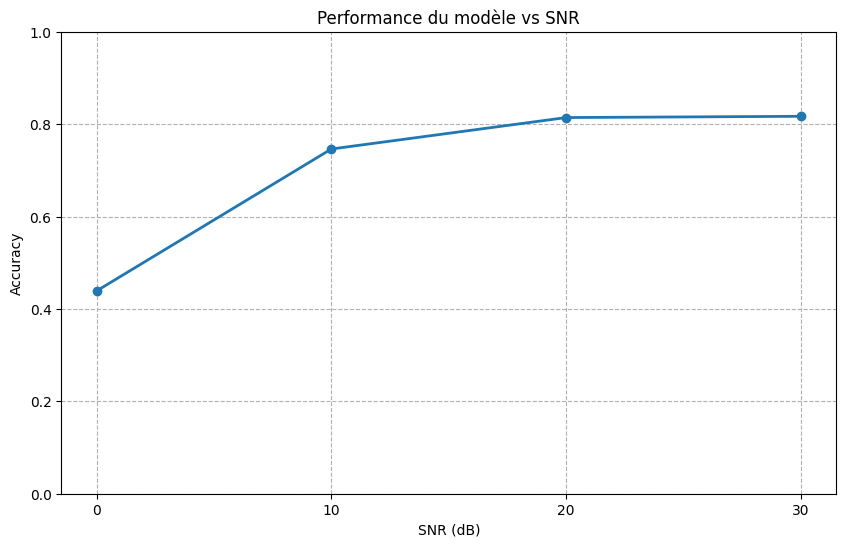


 3) Matrices de Confusion par SNR


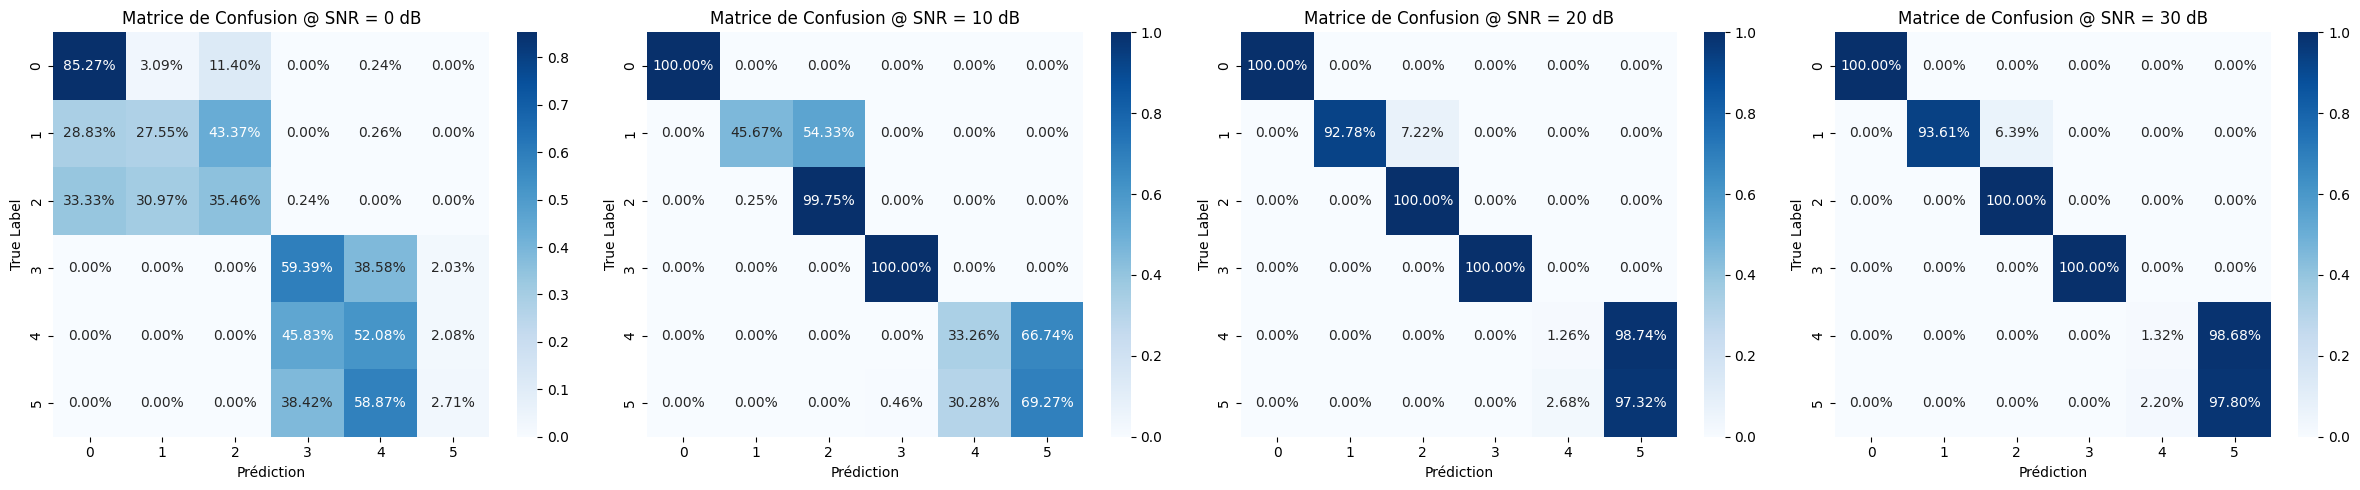

Fin du test.


In [ ]:
model = Conv1DNet(C_in=2, N_out=6)
model.load_state_dict(torch.load("conv_model_weights.pth"))
model.to(device)
# On met le modèle en mode évaluation
model.eval()

overall_accuracy_metric = MulticlassAccuracy(num_classes=6).to(device)
all_preds = []
all_labels = []
all_snr_list = []


with torch.no_grad():
    for batch_x, batch_y, batch_snr in test_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        batch_y_predicted = model(batch_x)

        overall_accuracy_metric.update(batch_y_predicted, batch_y)

        pred_classes = torch.argmax(batch_y_predicted, dim=1)
        all_preds.append(pred_classes.cpu().numpy())
        all_labels.append(batch_y.cpu().numpy())
        all_snr_list.append(batch_snr.cpu().numpy())


y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)
snr_array = np.concatenate(all_snr_list)

print("Inférence terminée.")

# 1) Accuracy Globale
print("\n 1) Accuracy Globale")
overall_acc = overall_accuracy_metric.compute()
print(f"Accuracy totale sur le set de test : {overall_acc.item()*100:.2f}%")


# 2) Graphique Accuracy vs SNR
print("\n 2) Graphique Accuracy vs SNR")
snr_levels = sorted(np.unique(snr_array))
snr_accuracies = []

for snr_val in snr_levels:
    # créer un masque pour chaque SNR
    mask = (snr_array == snr_val)
    if np.sum(mask) == 0: continue # skip si ce SNR n'est pas dans le set

    # filtrer les labels et prédictions
    snr_y_true = y_true[mask]
    snr_y_pred = y_pred[mask]

    acc = accuracy_score(snr_y_true, snr_y_pred)
    snr_accuracies.append(acc)
    print(f"Accuracy @ {int(snr_val)} dB: {acc*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(snr_levels, snr_accuracies, 'o-', linewidth=2)
plt.title('Performance du modèle vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--')
plt.xticks(snr_levels)
plt.ylim(0, 1.0)
plt.show()


# 3) Matrices de Confusion par SNR
print("\n 3) Matrices de Confusion par SNR")
class_names = [str(i) for i in range(6)]

# grille de graphiques (2x2 pour 4 niveaux de SNR)
num_snr = len(snr_levels)
fig, axes = plt.subplots(1, num_snr, figsize=(num_snr * 6, 5))

for ax, snr_val in zip(axes, snr_levels):

    # masque
    mask = (snr_array == snr_val)
    snr_y_true = y_true[mask]
    snr_y_pred = y_pred[mask]

    # matrice de confusion
    cm = confusion_matrix(snr_y_true, snr_y_pred, normalize='true')

    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'Matrice de Confusion @ SNR = {int(snr_val)} dB')
    ax.set_xlabel('Prédiction')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

print("Fin du test.")

*Comment*: Le 1er modèle est plutôt performant sur les données les moins bruitées (SNR élevé) et atteint ainsi 81% d'accuracy. Cependant, il est assez peut performant sur les données les plus bruitées (0 dB) et ne classe que 43,88% des signaux correctement. On obtient ainsi une accuracy générale de 70,68%.

## 2ème modèle : Résultats (Accuracy : 76,03%)

Inférence terminée.

 1) Accuracy Globale
Accuracy totale sur le set de test : 76.03%

 2) Graphique Accuracy vs SNR
Accuracy @ 0 dB: 47.85%
Accuracy @ 10 dB: 83.81%
Accuracy @ 20 dB: 84.91%
Accuracy @ 30 dB: 86.02%


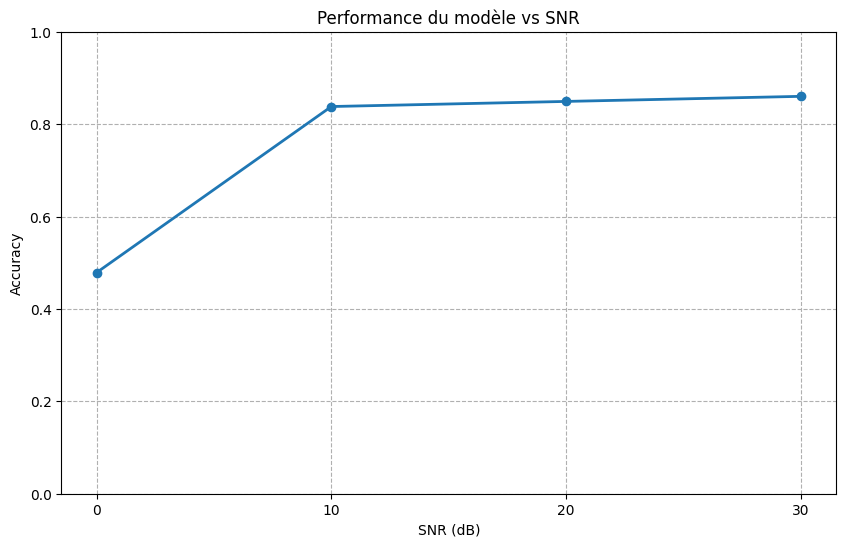


 3) Matrices de Confusion par SNR


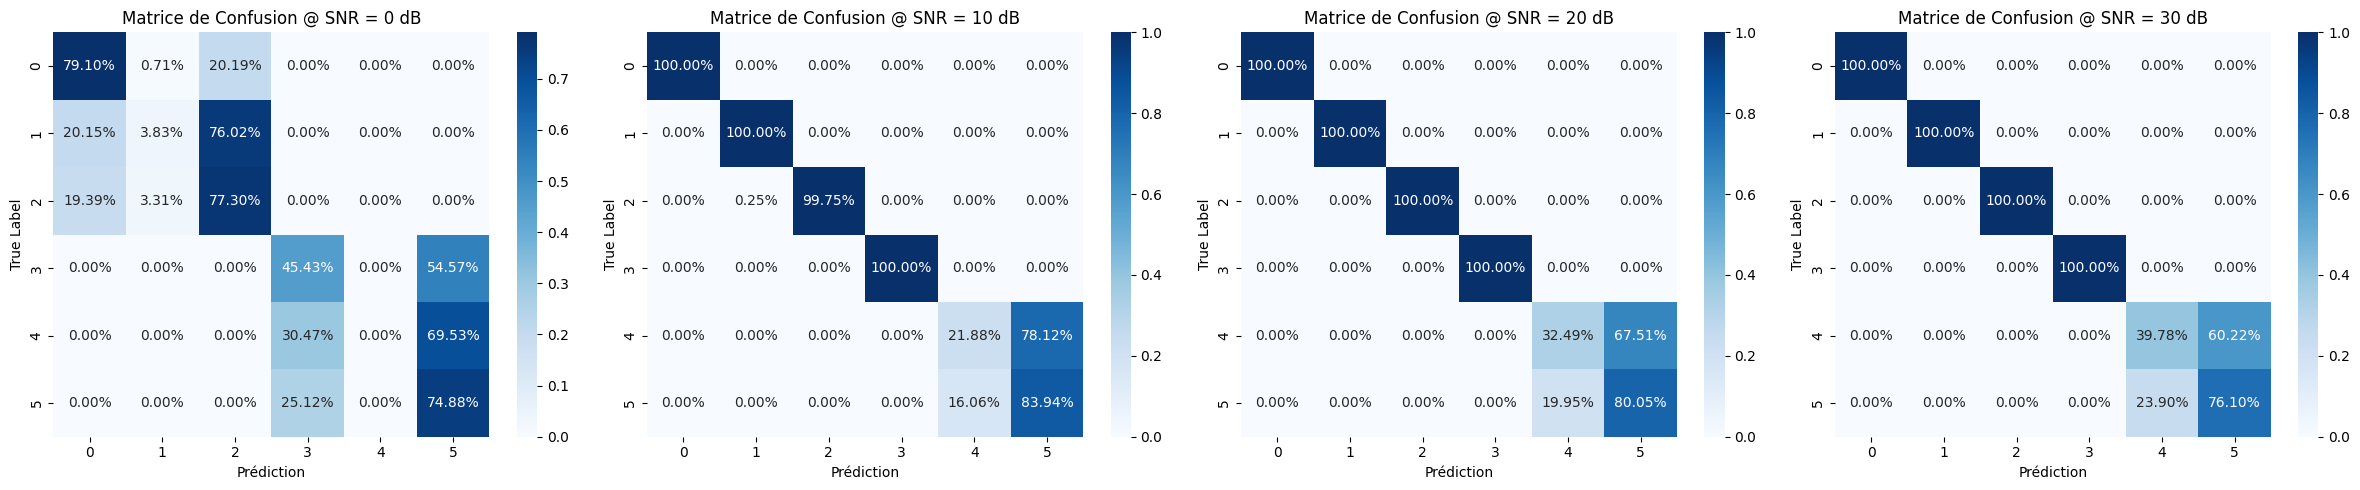

Fin du test.


In [ ]:
model = ComplexConv1DNet(C_in=2, N_out=6, dropout_rate=0.3)
model.load_state_dict(torch.load("complex2_conv_model_weights.pth"))
model.to(device)
# On met le modèle en mode évaluation
model.eval()

overall_accuracy_metric = MulticlassAccuracy(num_classes=6).to(device)
all_preds = []
all_labels = []
all_snr_list = []


with torch.no_grad():
    for batch_x, batch_y, batch_snr in test_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        batch_y_predicted = model(batch_x)

        overall_accuracy_metric.update(batch_y_predicted, batch_y)

        pred_classes = torch.argmax(batch_y_predicted, dim=1)
        all_preds.append(pred_classes.cpu().numpy())
        all_labels.append(batch_y.cpu().numpy())
        all_snr_list.append(batch_snr.cpu().numpy())


y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)
snr_array = np.concatenate(all_snr_list)

print("Inférence terminée.")

# 1) Accuracy Globale
print("\n 1) Accuracy Globale")
overall_acc = overall_accuracy_metric.compute()
print(f"Accuracy totale sur le set de test : {overall_acc.item()*100:.2f}%")


# 2) Graphique Accuracy vs SNR
print("\n 2) Graphique Accuracy vs SNR")
snr_levels = sorted(np.unique(snr_array))
snr_accuracies = []

for snr_val in snr_levels:
    # créer un masque pour chaque SNR
    mask = (snr_array == snr_val)
    if np.sum(mask) == 0: continue # skip si ce SNR n'est pas dans le set

    # filtrer les labels et prédictions
    snr_y_true = y_true[mask]
    snr_y_pred = y_pred[mask]

    acc = accuracy_score(snr_y_true, snr_y_pred)
    snr_accuracies.append(acc)
    print(f"Accuracy @ {int(snr_val)} dB: {acc*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(snr_levels, snr_accuracies, 'o-', linewidth=2)
plt.title('Performance du modèle vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--')
plt.xticks(snr_levels)
plt.ylim(0, 1.0)
plt.show()


# 3) Matrices de Confusion par SNR
print("\n 3) Matrices de Confusion par SNR")
class_names = [str(i) for i in range(6)]

# grille de graphiques (2x2 pour 4 niveaux de SNR)
num_snr = len(snr_levels)
fig, axes = plt.subplots(1, num_snr, figsize=(num_snr * 6, 5))

for ax, snr_val in zip(axes, snr_levels):

    # masque
    mask = (snr_array == snr_val)
    snr_y_true = y_true[mask]
    snr_y_pred = y_pred[mask]

    # matrice de confusion
    cm = confusion_matrix(snr_y_true, snr_y_pred, normalize='true')

    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'Matrice de Confusion @ SNR = {int(snr_val)} dB')
    ax.set_xlabel('Prédiction')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

print("Fin du test.")

*Comment:* Ce second modèle, qui est une version améliorée du premier, offre de très bonnes performances sur les données les moins bruitées (jusqu'à 86,02%) mais est plombé par les données avec un SNR de 0, puisqu'il ne les prédit correctement que dans 47,85% du temps (ce qui reste une nette amélioration par rapport au 1er modèle). On obtient ainsi une accuracy générale de 76,03%, ce qui reste un gain notable malgré la complexité accrue de ce modèle.

## 3ème modèle : Résultats (Accuracy : 86,02%)

Inférence terminée.

 1) Accuracy Globale
Accuracy totale sur le set de test : 86.02%

 2) Graphique Accuracy vs SNR
Accuracy @ 0 dB: 43.31%
Accuracy @ 10 dB: 99.04%
Accuracy @ 20 dB: 100.00%
Accuracy @ 30 dB: 100.00%


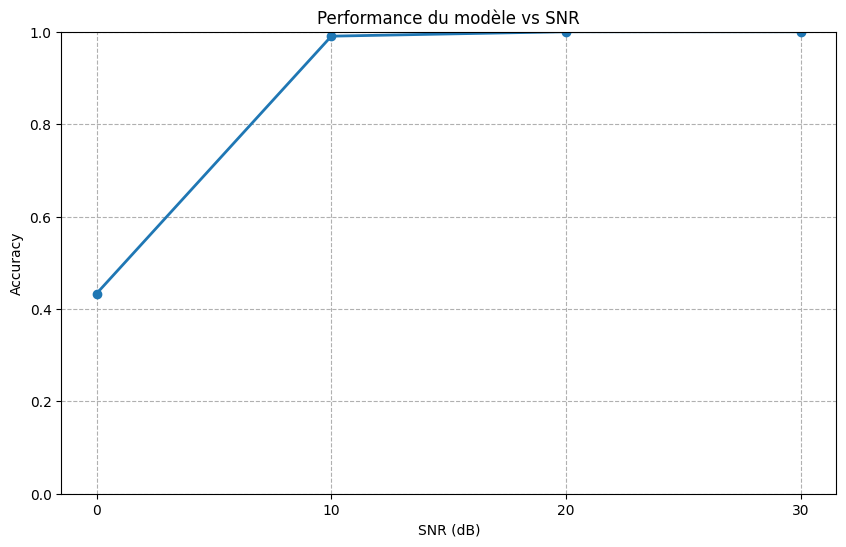


 3) Matrices de Confusion par SNR


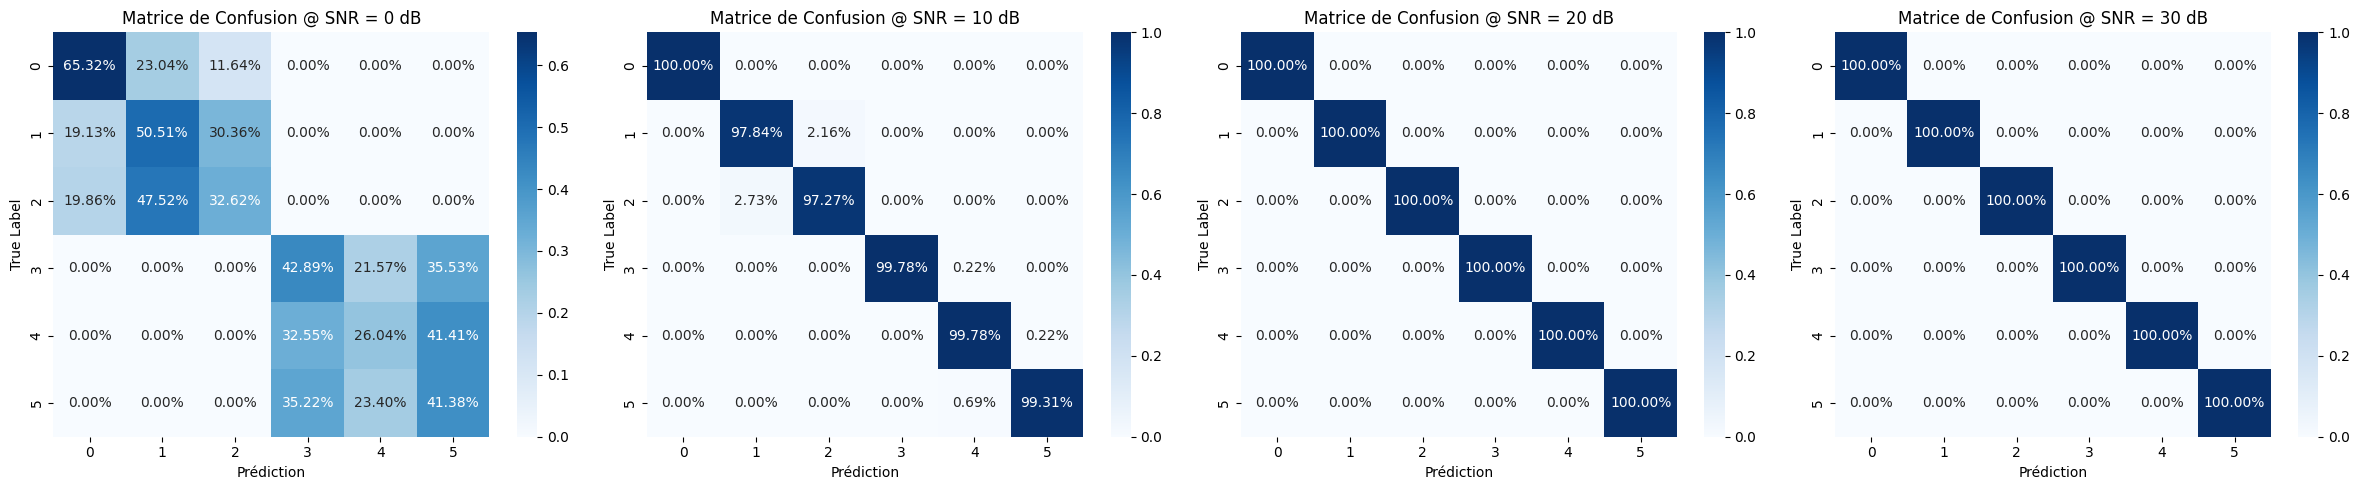

Fin du test.


In [ ]:
model = ResNetSignalNet(C_in=2, N_out=6, dropout_rate=0.3)
model.load_state_dict(torch.load("resnet_model_weights.pth"))
model.to(device)
# On met le modèle en mode évaluation
model.eval()

overall_accuracy_metric = MulticlassAccuracy(num_classes=6).to(device)
all_preds = []
all_labels = []
all_snr_list = []


with torch.no_grad():
    for batch_x, batch_y, batch_snr in test_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        batch_y_predicted = model(batch_x)

        overall_accuracy_metric.update(batch_y_predicted, batch_y)

        pred_classes = torch.argmax(batch_y_predicted, dim=1)
        all_preds.append(pred_classes.cpu().numpy())
        all_labels.append(batch_y.cpu().numpy())
        all_snr_list.append(batch_snr.cpu().numpy())


y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)
snr_array = np.concatenate(all_snr_list)

print("Inférence terminée.")

# 1) Accuracy Globale
print("\n 1) Accuracy Globale")
overall_acc = overall_accuracy_metric.compute()
print(f"Accuracy totale sur le set de test : {overall_acc.item()*100:.2f}%")


# 2) Graphique Accuracy vs SNR
print("\n 2) Graphique Accuracy vs SNR")
snr_levels = sorted(np.unique(snr_array))
snr_accuracies = []

for snr_val in snr_levels:
    # créer un masque pour chaque SNR
    mask = (snr_array == snr_val)
    if np.sum(mask) == 0: continue # skip si ce SNR n'est pas dans le set

    # filtrer les labels et prédictions
    snr_y_true = y_true[mask]
    snr_y_pred = y_pred[mask]

    acc = accuracy_score(snr_y_true, snr_y_pred)
    snr_accuracies.append(acc)
    print(f"Accuracy @ {int(snr_val)} dB: {acc*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(snr_levels, snr_accuracies, 'o-', linewidth=2)
plt.title('Performance du modèle vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--')
plt.xticks(snr_levels)
plt.ylim(0, 1.0)
plt.show()


# 3) Matrices de Confusion par SNR
print("\n 3) Matrices de Confusion par SNR")
class_names = [str(i) for i in range(6)]

# grille de graphiques (2x2 pour 4 niveaux de SNR)
num_snr = len(snr_levels)
fig, axes = plt.subplots(1, num_snr, figsize=(num_snr * 6, 5))

for ax, snr_val in zip(axes, snr_levels):

    # masque
    mask = (snr_array == snr_val)
    snr_y_true = y_true[mask]
    snr_y_pred = y_pred[mask]

    # matrice de confusion
    cm = confusion_matrix(snr_y_true, snr_y_pred, normalize='true')

    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'Matrice de Confusion @ SNR = {int(snr_val)} dB')
    ax.set_xlabel('Prédiction')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

print("Fin du test.")

*Comment:* L'accuracy générale du ResNet est excellente : 86,02%. On observe que l'on obtient une classification parfaite ou quasi-parfaite sur les données les moins bruitées. Cependant la performance sur les données les plus bruitées est toujours assez mauvaise. Néanmoins, même ramené à la complexité du modèle, nous considérons l'amélioration générale de l'accuracy comme justifiant l'usage d'un tel modèle.

### Conclusion :

Nous obtenons avec notre meilleur modèle une très bonne métrique d'accuracy. Le problème restant est la classification des signaux très bruités, pour lequel ce modèle échoue. Une possiibilité serait d'effectuer de l'augmentation de données bruitées, ou de bruiter certaines données existantes, afin d'entraîner le réseau de neurones à davantage reconnaître ces signaux.